<a href="https://colab.research.google.com/github/NemethKrisztian96/Accelerometer-based-gait-recognition/blob/master/FeatureExtractionAndMeasurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive in order to use as dataset source

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Flatten
from keras.layers import Input, Dense
from keras.layers import Reshape
from keras.models import Model
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from keras.utils import plot_model

Using TensorFlow backend.


Settings and global attributes

In [0]:
# Random states for reproducibility
RANDOM_STATE = np.random.seed(0)

# input frame size
FRAME_SIZE = 128

SESSION0 = 22
SESSION1 = 153
SESSION2 = 153
SESSIONS = ['session_0/', 'session_1/', 'session_2/']

# change these to the according paths
FILES_PATH = '/content/drive/My Drive/Colab Notebooks/zju-gaitacc/'
# FILES_PATH = '../../GaitBiometricsData/zju-gaitacc/zju-gaitacc/'
FEATURES_DIR = '/content/drive/My Drive/Colab Notebooks/zju-gaitacc/Features/'
# FEATURES_DIR = './Features/'

# manual features
# change this according to the file that has to be used for classification
FEATURE_FILE = 'gaitacc128_session0.csv'
# FEATURE_FILE = 'gaitacc128_session1.csv'
# FEATURE_FILE = 'gaitacc128_session2.csv'

# automatic features
# change this according to the encoded session that has to be classified
ENCODED_FILE = "session_0.csv"
# ENCODED_FILE = "session_1.csv"
# ENCODED_FILE = "session_2.csv"

##Utility functions for different tasks

For loading dataset

In [0]:
def load_session_files_list (session_number):
    """Loads a list with the files that have to be loaded"""
    
    users = []
    for i in range(1, session_number + 1):
        if i < 10:
            for j in range(1, 7):
                users.append("subj_00" + str(i) + '/rec_' + str(j) + '/3.txt')
        elif i < 100:
            for j in range(1, 7):
                users.append("subj_0" + str(i) + '/rec_' + str(j) + '/3.txt')
        else:
            for j in range(1, 7):
                users.append("subj_" + str(i) + '/rec_' + str(j) + '/3.txt')
    return users


def load_dataset (path, files_list, session_index):
    """Loads the a session of the dataset from the given path and returns the 
    data in a (samples, frame_size=128, 3) shape numpy array"""
    
    print("Loading...")
    data = load_file(path + SESSIONS[session_index] + files_list[0])
    labels = [files_list[0][5:8]] * len(data)
    for name in files_list[1:]:
        print(name)
        loaded = load_file(path + SESSIONS[session_index] + name)
        data = np.vstack((data, loaded))
        labels += [name[5:8]] * len(loaded)
    print("Loaded shape:", data.shape)
    print("Labels:", len(labels))
    return data, labels


def load_file (file):
    """Loads the contents of one given file"""
    
    # files contain data for each axis on separate rows
    with open(file) as f:
        axis_x = f.readline()
        axis_y = f.readline()
        axis_z = f.readline()
        axis_x = axis_x.strip('\n').split(',')
        axis_y = axis_y.strip('\n').split(',')
        axis_z = axis_z.strip('\n').split(',')

        if len(axis_x) != len(axis_y) and len(axis_x) != len(axis_z):
            raise Exception("Corrupted file: " + file)

        counter = 0
        # remove the last step if it is < 128 data points long
        length = len(axis_x) - (len(axis_x) % 128)
        arr = np.empty(shape=(length // 128, 128, 3))
        for i in range(length):
            sample = i // 128
            arr[sample][counter][0] = float(axis_x[i])
            arr[sample][counter][1] = float(axis_y[i])
            arr[sample][counter][2] = float(axis_z[i])
            counter += 1
            if counter == 128:
                counter = 0
    return arr


Complementary functions for measuring classification performance

In [0]:
def performance_measure (y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i]:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1

    return TP, FP, TN, FN


def calc_sensitivity (y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    # row = false positive, column = false negative
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i == j:
                TP += cm[i][i]
            else:
                FN += cm[j][i]
    return TP / (TP + FN)

## Autoencoder

In [0]:
def dense_autoencoder (activation_function='tanh'):
    data0, ydata0 = load_dataset(FILES_PATH, load_session_files_list(SESSION0), 0)
    data1, ydata1 = load_dataset(FILES_PATH, load_session_files_list(SESSION1), 1)
    data2, ydata2 = load_dataset(FILES_PATH, load_session_files_list(SESSION2), 2)

    data = np.concatenate((data0, data1, data2), axis=0)
    ydata = np.concatenate((ydata0, ydata1, ydata2), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(data, ydata, test_size=0.2, random_state=RANDOM_STATE)

    SEQUENCE_LENGTH, width, depth = 128, 3, 1

    input_size = SEQUENCE_LENGTH * 3
    input_frame = Input(shape=(SEQUENCE_LENGTH, 3))
    # x = Dense(SEQUENCE_LENGTH, activation='linear', kernel_initializer=init.ones(), trainable=False)(input_frame)
    x = Flatten()(input_frame)
    x = Dense(input_size, activation=activation_function)(x)
    encoded = Dense(320, activation=activation_function)(x)
    encoded = Dense(256, activation=activation_function)(encoded)
    encoded = Dense(192, activation=activation_function)(encoded)
    encoded = Dense(128, activation=activation_function)(encoded)
    encoded = Dense(96, activation=activation_function)(encoded)
    encoded = Dense(64, activation=activation_function)(encoded)
    encoded = Dense(48, activation=activation_function)(encoded)

    y = Dense(22, activation=activation_function)(encoded)

    decoded = Dense(48, activation=activation_function)(y)
    decoded = Dense(64, activation=activation_function)(decoded)
    decoded = Dense(96, activation=activation_function)(decoded)
    decoded = Dense(128, activation=activation_function)(decoded)
    decoded = Dense(192, activation=activation_function)(decoded)
    decoded = Dense(256, activation=activation_function)(decoded)
    decoded = Dense(320, activation=activation_function)(decoded)
    z = Dense(input_size, activation=activation_function)(decoded)
    z = Reshape(target_shape=(128, 3))(z)
    autoencoder = Model(input_frame, z)

    # encoder is the model of the autoencoder slice in the middle
    encoder = Model(input_frame, y)

    autoencoder.compile(optimizer='adadelta', loss='mse')  # reporting the loss
    print(autoencoder.summary())
    plot_model(autoencoder, show_shapes=True, to_file='/content/drive/My Drive/Colab Notebooks/encoder.png')
    history = autoencoder.fit(X_train, X_train,
                              epochs=20,
                              batch_size=16,
                              shuffle=True,
                              validation_data=(X_test, X_test))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Veszteség')
    plt.ylabel('Veszteség')
    plt.xlabel('Korszak')
    plt.xticks(np.arange(0, 20, 1.0))
    plt.legend(['Tanítás', 'Validáció'], loc='upper right')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/autoencoder_loss', dpi=200)
    plt.show()
    return encoder

Function for extracting features using the encoder

In [0]:
def extract_features (encoder, session, session_idx):
    print('Extracting features...')
    # Load raw data and segment into frames

    session_files = load_session_files_list(session)

    data, ydata = load_dataset(FILES_PATH, session_files, session_idx)

    print('data shape: ', str(data.shape))
    # Extract features
    encoded_frames = encoder.predict(data)
    print(encoded_frames.shape)

    # Normalize data
    scaled_data = preprocessing.scale(encoded_frames)
    # scaled_data = encoded_frames
    num_features = encoded_frames.shape[1]

    # Concatenate features(encoded_frames) with labels (ydata)
    df1 = pd.DataFrame(data=scaled_data)
    # df1 = df1.assign(pd.Series(ydata[1]).values)
    df2 = pd.DataFrame(data=ydata, columns=[64])
    df3 = pd.concat([df1, df2], axis=1)

    # Save data into a CSV file
    out_file = FEATURES_DIR + SESSIONS[session_idx][:-1] + ".csv"
    df3.to_csv(out_file, header=False, index=False)

    print("Saved to: " + out_file)

##Extracting automatic features

subj_153/rec_6/3.txt


W0704 10:43:13.988077 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 10:43:14.021299 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:43:14.042290 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Loaded shape: (8897, 128, 3)
Labels: 8897


W0704 10:43:14.230103 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 3)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_2 (Dense)              (None, 320)               123200    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               82176     
_________________________________________________________________
dense_4 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               24704     
__________

W0704 10:43:15.177799 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0704 10:43:15.185001 140250607974272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 15464 samples, validate on 3866 samples
Epoch 1/20
15464/15464 [==============================] - 14s 933us/step - loss: 0.0646 - val_loss: 0.0487
Epoch 2/20
15464/15464 [==============================] - 10s 658us/step - loss: 0.0459 - val_loss: 0.0437
Epoch 3/20
15464/15464 [==============================] - 10s 649us/step - loss: 0.0427 - val_loss: 0.0417
Epoch 4/20
15464/15464 [==============================] - 10s 656us/step - loss: 0.0411 - val_loss: 0.0431
Epoch 5/20
15464/15464 [==============================] - 10s 654us/step - loss: 0.0398 - val_loss: 0.0399
Epoch 6/20
15464/15464 [==============================] - 10s 654us/step - loss: 0.0387 - val_loss: 0.0385
Epoch 7/20
15464/15464 [==============================] - 10s 659us/step - loss: 0.0378 - val_loss: 0.0388
Epoch 8/20
15464/15464 [==============================] - 10s 647us/step - loss: 0.0369 - val_loss: 0.0367
Epoch 9/20
15464/15464 [==============================] - 10s 649us/step - loss: 0.0363 - val_l

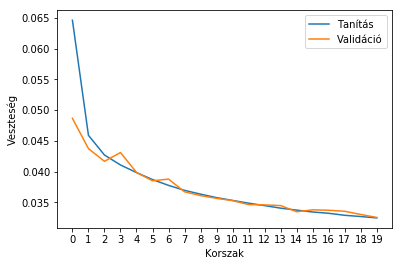

In [8]:
encoder = dense_autoencoder()

In [0]:
extract_features(encoder, SESSION0, 0)

Save/load trained model

In [0]:
MODEL_LOCATION = '/content/drive/My Drive/Colab Notebooks/'

# save
encoder.save(MODEL_LOCATION + 'dense_encoder.h5')
print("Saved model to disk")

# load
from keras.models import load_model
encoder = load_model(MODEL_LOCATION + 'dense_encoder.h5')
encoder.summary()

Saved model to disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 3)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 384)               147840    
_________________________________________________________________
dense_68 (Dense)             (None, 320)               123200    
_________________________________________________________________
dense_69 (Dense)             (None, 256)               82176     
_________________________________________________________________
dense_70 (Dense)             (None, 196)               50372     
_________________________________________________________________
dense_71 (Dense)             (None, 128)               2

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Classification using SVM

###Function definitions for classification

In [0]:
def svm_manual_features (with_scaling=False):
    file = FEATURES_DIR + FEATURE_FILE
    csvdf = pd.read_csv(file, sep=',')
    csvdf['userID'] = [int(value[1:]) for value in csvdf['userID']]
    labels = csvdf.iloc[:, -1]
    csvdf = csvdf.iloc[:, :-1]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(csvdf, labels, test_size=0.25)
    
    if with_scaling:
        # Standard scaling
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)

    # Create SVM classifier
    classifier_svm_kernel = SVC(C=100.0, kernel='rbf', gamma='scale', tol=0.00001, decision_function_shape='ovo',
                                verbose=True)
    classifier_svm_kernel.fit(X_train, y_train)

    # Predict the result for test values
    y_pred = classifier_svm_kernel.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print(classification_report(y_test, y_pred))
    # print(accuracy_score(y_test, y_pred))
    print("Sensitivity:", calc_sensitivity(y_test, y_pred))

In [0]:
def svm_autoencoder_features (with_scaling=False):
    file = FEATURES_DIR + ENCODED_FILE
    csvdf = pd.read_csv(file, sep=',')
    labels = csvdf.iloc[:, -1]
    csvdf = csvdf.iloc[:, :-1]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(csvdf, labels, test_size=0.25)

    if with_scaling:
        # Standard scaling
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)

    # Create SVM classifier
    classifier_svm_kernel = SVC(C=100.0, kernel='rbf', gamma='scale', tol=0.00001, decision_function_shape='ovo',
                                verbose=True)
    classifier_svm_kernel.fit(X_train, y_train)

    # Predict the result for test values
    y_pred = classifier_svm_kernel.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print(classification_report(y_test, y_pred))
    # print(accuracy_score(y_test, y_pred))
    print("Sensitivity:", calc_sensitivity(y_test, y_pred))

###Test cases

####1. Manual features from the FeatureExtractorLibrary

In [0]:
FEATURE_FILE = 'gaitacc128_session0.csv'
svm_manual_features(True)

[LibSVM][[20  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0 17  0  2  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 1  0  0 13  0  0  0  0  0  1  2  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 16  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  1  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 12  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  8  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  1 13  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  2  0  0  0  0  0  0  0  0  0  9  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 

####2. SVM on automatic features

In [0]:
ENCODED_FILE = "session_0.csv"
svm_autoencoder_features()

[LibSVM][[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  1  0  0  0  2  0  0  0  0  2  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  0 14  0  0  0  0  1  0  2  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  2  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  1  2  0  1  0  1  1  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  9  0  1  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  5  0  1  0  0  0  0  0  0  2  0  0  0  2]
 [ 0  1  0  0  0  0  0  1  0  7  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  2  0  2  0  0  8  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  2  0  2  0  0  1  0  0  0  1  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 